In [1]:
from keras.applications.mobilenetv2 import MobileNetV2, preprocess_input, decode_predictions
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.preprocessing import image
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from keras.models import Model, load_model
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import itertools
import time
import cv2
import os

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
   This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{0:.2f}'.format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return None

In [3]:
def load_image(path):
    x = cv2.imread(path)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (224,224)).astype(np.float32)
#     x = image.load_img(path, target_size=(224,224))
#     x = image.img_to_array(x)
    return x

In [4]:
base_path = 'Data/images/'
images_path = []
labels = []

for path in os.listdir(base_path):
    for img_path in os.listdir(os.path.join(base_path, path)):
        images_path.append(os.path.join(base_path, path, img_path))
        labels.append(path)

In [5]:
train_paths, val_paths, train_labels, val_labels = train_test_split(images_path, labels, 
                                                                      test_size=0.1, random_state=7, 
                                                                      stratify=labels)

In [8]:
X_train = np.array([load_image(impath) for impath in train_paths])
print('Training size: ', len(train_paths))

Training size:  413


In [9]:
X_val = np.array([preprocess_input(load_image(impath)) for impath in val_paths])
print('Testing size: ', len(val_paths))

Testing size:  46


In [11]:
X_train.shape

(413, 224, 224, 3)

In [12]:
train_gen = image.ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input)

train_gen.fit(X_train)

In [6]:
enc = LabelEncoder()
enc.fit(train_labels)
print(enc.classes_)

['lipstick_a' 'lipstick_b' 'lipstick_c' 'perfume_a_leyenda'
 'perfume_b_fascina' 'perfume_c_inspira']


In [14]:
y_train = enc.transform(train_labels)
y_train = to_categorical(y_train)

In [15]:
y_val = enc.transform(val_labels)
y_val = to_categorical(y_val)

In [57]:
base_model = MobileNetV2(input_shape=(224,224,3), weights='imagenet', include_top=False)

In [58]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(6, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional layers
for layer in base_model.layers:
    layer.trainable = False

In [59]:
for layer in base_model.layers:
    for i in range(10,17,1):
        if layer.name.startswith('block_{}'.format(i)):
            layer.trainable = True

In [60]:
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['acc'])

In [61]:
batch_size = 32
epochs = 20

In [62]:
train_datagen = train_gen.flow(X_train, y_train, batch_size=batch_size)

In [63]:
# model.fit(X_train, y_onehot, batch_size=batch_size, epochs=epochs)
tensorboard = TensorBoard(log_dir='./logs/{}'.format(time.time()), update_freq='batch')

history = model.fit_generator(
    generator=train_datagen, 
    steps_per_epoch=np.ceil(len(y_train)/batch_size),
    validation_data=(X_val, y_val),
    epochs=epochs, callbacks=[tensorboard])

Epoch 1/20
13/13 [==============================] - 4s 299ms/step - loss: 1.2963 - acc: 0.5465 - val_loss: 0.8515 - val_acc: 0.7174
Epoch 2/20
13/13 [==============================] - 3s 262ms/step - loss: 0.3727 - acc: 0.9493 - val_loss: 0.3798 - val_acc: 0.9348
Epoch 3/20
13/13 [==============================] - 3s 213ms/step - loss: 0.1118 - acc: 0.9784 - val_loss: 0.2717 - val_acc: 0.9130
Epoch 4/20
13/13 [==============================] - 3s 214ms/step - loss: 0.0411 - acc: 1.0000 - val_loss: 0.1948 - val_acc: 0.9130
Epoch 5/20
13/13 [==============================] - 3s 212ms/step - loss: 0.0251 - acc: 1.0000 - val_loss: 0.1458 - val_acc: 0.9565
Epoch 6/20
13/13 [==============================] - 3s 212ms/step - loss: 0.0151 - acc: 1.0000 - val_loss: 0.1361 - val_acc: 0.9565
Epoch 7/20
13/13 [==============================] - 3s 214ms/step - loss: 0.0146 - acc: 1.0000 - val_loss: 0.1718 - val_acc: 0.9348
Epoch 8/20
13/13 [==============================] - 3s 214ms/step - loss: 0.

In [64]:
img_test = load_image('Data/images_test/lipstick_a/IMG_20181011_144348.jpg')
img_test = preprocess_input(img_test)
img_test = np.expand_dims(img_test, 0)

pred = model.predict(img_test)
print(enc.inverse_transform(np.argmax(pred)))

lipstick_a


/home/deepai/.conda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [68]:
# model.save('model-v2')

In [65]:
test_path = r'Data/images_test/'
test_images_path = []
test_labels = []

for path in os.listdir(test_path):
    for img_path in os.listdir(os.path.join(test_path, path)):
        test_images_path.append(os.path.join(test_path, path, img_path))
        test_labels.append(path)

In [52]:
X_test = np.array([preprocess_input(load_image(impath)) for impath in test_images_path])
print('Testing size: ', len(X_test))

Testing size:  78


In [53]:
y_test = enc.transform(test_labels)
y_test = to_categorical(y_test)

In [66]:
l, a = model.evaluate(X_test, y_test)
print('loss: {}  accuracy: {}'. format(l,a))

78/78 [==============================] - 0s 2ms/step
loss: 0.09210174196423629  accuracy: 0.9615384615384616


/home/deepai/.conda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/deepai/.conda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


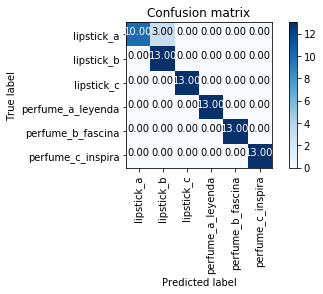

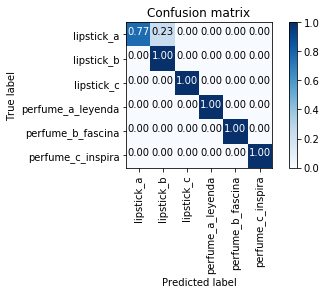

In [67]:
y_test_pred = model.predict(X_test)
y_test_pred_labels = enc.inverse_transform(np.argmax(y_test_pred,axis=1))

y_test_labels = enc.inverse_transform(np.argmax(y_test, axis=1))

cm = metrics.confusion_matrix(y_true=y_test_labels,y_pred=y_test_pred_labels, labels=enc.classes_)
plt.figure()
plot_confusion_matrix(cm,enc.classes_,normalize=False)
plt.figure()
plot_confusion_matrix(cm,enc.classes_,normalize=True)

In [76]:
def standard_scaler(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

Pred: lipstick_b, True: lipstick_a


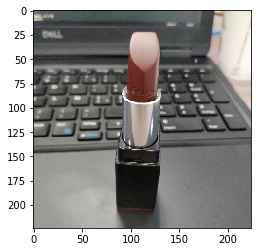

In [84]:
idx=2

error_mask = (y_test_pred_labels != y_test_labels)
print('Pred: {}, True: {}'. format(y_test_pred_labels[error_mask][idx], y_test_labels[error_mask][idx]))

plt.imshow(standard_scaler(X_test[error_mask][idx]))

In [7]:
model = load_model('model-v2-96')

In [8]:
cap = cv2.VideoCapture(0)

while cap.isOpened():
    
    ret, frame = cap.read()
    
    if not ret:
        print('false')
        break
        
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224)).astype(np.float32)
    img = preprocess_input(img)
    
    pred = model.predict(np.expand_dims(img, 0))
    
    label = enc.inverse_transform(np.argmax(pred))
    
    text_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_DUPLEX, 1, 2)
    cv2.rectangle(frame, (0,0), (text_size[0][0],text_size[0][1]+10), (0,0,0), -1)
    cv2.putText(frame, label, (0,text_size[0][1]), cv2.FONT_HERSHEY_DUPLEX, 1, (255,255,255), 2)
    
    cv2.imshow('frame',frame)
    
    k = cv2.waitKey(30)
    if k == ord('q'): 
        break
        
cv2.destroyAllWindows()
cap.release()